In [2]:
import codecs
import numpy as np
import pandas as pd
import gensim
import io
import re
import sys

from keras.utils import np_utils
from keras.layers import Dense, LSTM, Input, Dropout
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Input

from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

# Задача А: предсказание добычи за второй год по данным о добыче за первый

In [3]:
###########################################################
## Model_prod are learned using "Production" (24 months) ##
###########################################################

production = pd.read_excel('production2years.xlsx')
print("Production 1-24 months:")
display(production.head())

n_months = 12
n_months_predict = 24
history_len = 126
n_graph = 6

data_prod = production.values
max_prod = data_prod.max()
data_prod = data_prod / data_prod.max()
data_prod = data_prod[:, :, np.newaxis]

data_prod_tr = data_prod[:int(data_prod.shape[0]*0.75)]
data_prod_tst = data_prod[int(data_prod.shape[0]*0.75):]
print("data_train shape:", data_prod_tr.shape)
print("data_test shape:", data_prod_tst.shape)

x_data_prod = [data_prod_tr[:, i:i+n_months] for i in range(n_months-1)]
y_data_prod = [data_prod_tr[:, i+1:i+n_months+1] for i in range(n_months-1)]

x_data_prod = np.concatenate(x_data_prod, axis=0)
y_data_prod = np.concatenate(y_data_prod, axis=0)
print("x_data shape:", y_data_prod.shape)

Production 1-24 months:


,30,60,90,120,150,180,210,240,270,300,...,450,480,510,540,570,600,630,660,690,720
0,67.4941,89.1393,103.3100,113.689,120.6310,157.0800,153.7660,158.0670,163.423,167.826,...,180.2370,181.3450,181.9340,183.3200,183.9740,185.9750,188.0300,188.4100,189.6560,191.0720
1,119.0390,158.2370,174.1520,196.079,236.6280,241.6010,250.8850,256.4400,259.848,260.841,...,258.8160,259.9990,262.4050,263.6160,265.8880,268.2720,271.0190,273.9610,277.0930,281.2540
2,105.2020,147.0960,160.8720,208.552,223.8190,232.8640,240.8040,247.8540,253.325,255.225,...,254.4450,254.5040,255.4000,258.0000,261.4130,265.7960,270.2820,276.6710,283.6450,292.2320
3,33.8452,37.0500,40.3715,42.894,44.6663,46.0704,47.2206,48.2475,49.097,49.875,...,53.2589,53.8843,54.5180,55.1782,55.8971,56.7072,57.6837,58.9830,61.0493,67.4712
4,163.6050,244.1620,264.1410,286.023,296.6880,300.8600,303.6640,320.9160,278.395,174.037,...,54.0066,50.6139,41.6363,30.3179,27.0217,26.6928,26.5875,26.4559,26.3763,26.3106


data_train shape: (150, 24, 1)
data_test shape: (50, 24, 1)
x_data shape: (1650, 12, 1)


In [4]:
inp = Input(shape=(n_months, 1))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(1, activation="relu")(lstm)

model_prod = Model(inp, out)
model_prod.summary()
model_prod.compile(optimizer='adam', loss='mse', metrics=['mae'])
callback_prod = TensorBoard(log_dir='./logs/prod', profile_batch = 100000000)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
dense_1 (Dense)              (None, 12, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model_prod.fit(x_data_prod, y_data_prod, epochs=20, callbacks=[callback_prod])

Epoch 1/20
1650/1650 [==============================] - 1s 733us/step - loss: 0.0578 - mae: 0.1891
Epoch 2/20
1650/1650 [==============================] - 1s 354us/step - loss: 0.0222 - mae: 0.1076
Epoch 3/20
1650/1650 [==============================] - 1s 362us/step - loss: 0.0151 - mae: 0.0856
Epoch 4/20
1650/1650 [==============================] - 1s 365us/step - loss: 0.0107 - mae: 0.0696
Epoch 5/20
1650/1650 [==============================] - 1s 360us/step - loss: 0.0079 - mae: 0.0584
Epoch 6/20
1650/1650 [==============================] - 1s 357us/step - loss: 0.0061 - mae: 0.0496
Epoch 7/20
1650/1650 [==============================] - 1s 361us/step - loss: 0.0046 - mae: 0.0413
Epoch 8/20
1650/1650 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.036 - 1s 352us/step - loss: 0.0036 - mae: 0.0361
Epoch 9/20
1650/1650 [==============================] - 1s 381us/step - loss: 0.0029 - mae: 0.0313
Epoch 10/20
1650/1650 [==============================] - 1s 365us/step 

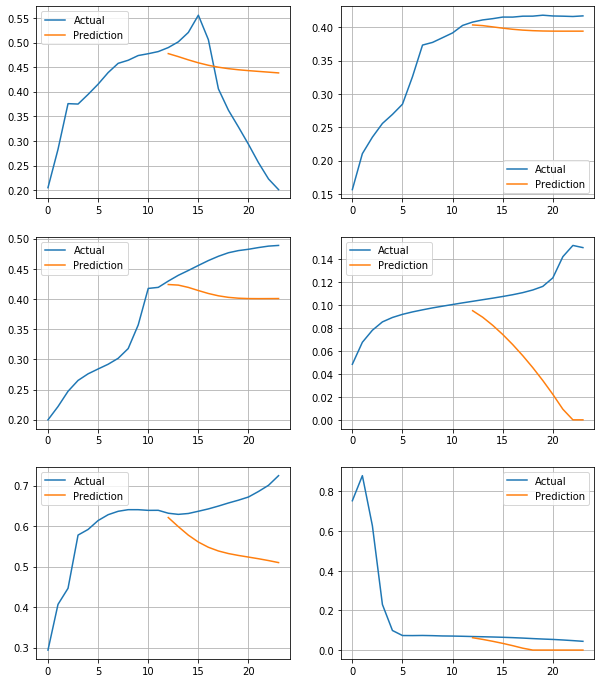

In [7]:
x_prod_tst = data_prod_tst[:, :n_months]
predicts_prod = np.zeros((x_prod_tst.shape[0], 0, x_prod_tst.shape[2]))

for i in range(n_months):
    x_prod = np.concatenate((x_prod_tst[:, i:], predicts_prod), axis=1)
    pred_prod = model_prod.predict(x_prod)
    last_pred_prod = pred_prod[:, -1:]
    predicts_prod = np.concatenate((predicts_prod, last_pred_prod), axis=1)

plt.figure(figsize=(10, 2*n_graph))
for iapi in range(n_graph):
    plt.subplot(n_graph/2, 2, iapi+1)
    plt.plot(np.arange(data_prod_tst.shape[1]), data_prod_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts_prod.shape[1])+x_prod_tst.shape[1], predicts_prod[iapi, :, 0], label='Prediction')
    plt.legend()
    plt.grid()
plt.show()

# Задача B: предсказание добычи за второй год по данным о добыче, закачке и давлении за первый

In [8]:
###############################################################################################
## Model_pres_inj are learned using "Production", "Pressure" and "Gas injection" (24 months) ##
###############################################################################################

pressure = pd.read_excel('pressure.xlsx')
gas_inj = pd.read_excel('gas_injection.xlsx')
print("Pressure 1-24 months:")
display(pressure.head())
print("Gas injection 1-24 months:")
display(gas_inj.head())

data_press = pressure.values
data_press = data_press / data_press.max()
data_inj = gas_inj.values
data_inj = data_inj / data_inj.max()

data_prod = data_prod.reshape(data_prod.shape[0], data_prod.shape[1])
data = np.stack((data_prod, data_press, data_inj), axis=-1)
                
data_tr = data[:int(data.shape[0]*0.75)]
data_tst = data[int(data.shape[0]*0.75):]

print("data_train shape:", data_tr.shape)
print("data_test shape:", data_tst.shape)

#display(data[0])

x_data = [data_tr[:, i:i+n_months] for i in range(n_months-1)]
y_data = [data_tr[:, i+1:i+n_months+1] for i in range(n_months-1)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print("x_data shape:", x_data.shape)

Pressure 1-24 months:


,30,60,90,120,150,180,210,240,270,300,...,450,480,510,540,570,600,630,660,690,720
0,289.906,317.845,334.199,342.467,348.298,341.474,326.143,321.961,319.685,318.177,...,312.224,311.120,309.939,308.997,308.175,307.840,307.664,307.265,306.987,306.830
1,295.437,331.690,345.858,352.602,334.797,325.072,321.214,319.136,316.981,314.610,...,308.459,308.101,307.985,307.808,307.724,307.730,307.749,307.711,307.456,307.107
2,298.324,340.326,353.192,355.835,337.213,329.253,325.171,322.318,320.276,318.545,...,310.550,309.652,309.436,309.558,309.735,309.829,309.749,309.653,309.336,308.751
3,341.579,350.815,357.668,362.476,365.728,368.250,370.260,372.009,373.370,374.576,...,379.174,379.879,380.529,381.129,381.702,382.221,382.686,383.086,383.358,383.075
4,336.864,335.872,317.297,317.299,317.744,314.564,309.848,304.712,269.933,250.424,...,242.838,242.798,242.895,242.834,242.541,242.478,242.458,242.434,242.401,242.364


Gas injection 1-24 months:


,30,60,90,120,150,180,210,240,270,300,...,450,480,510,540,570,600,630,660,690,720
0,61.1292,51.9591,48.2519,48.5935,49.9207,60.4800,89.0797,105.4380,118.7250,131.3360,...,193.1020,203.8570,214.4520,223.8630,232.5140,239.3320,245.4700,251.6150,257.0550,261.8230
1,98.7667,78.7714,72.1009,73.0969,112.2440,147.3000,170.9340,190.5450,210.1360,229.6610,...,292.3670,299.4260,305.0260,310.4600,315.1020,319.2120,323.0850,326.9890,331.6610,336.5930
2,109.2530,75.4585,66.9732,71.9963,117.8850,149.3290,173.1120,193.7780,212.7110,230.4910,...,300.5400,309.4250,315.3940,319.6020,323.3260,327.3520,331.9860,336.6890,342.1710,348.5600
3,25.9040,24.1286,22.5020,21.3964,20.8578,20.4179,20.1865,19.9663,20.0862,20.1715,...,20.7689,20.9385,21.1148,21.3085,21.4934,21.7389,22.0331,22.4175,22.9687,24.1002
4,70.3023,111.7680,202.0880,244.7750,276.2800,314.0380,352.4610,389.1300,549.3920,653.5760,...,708.4470,710.4800,710.9830,711.7260,713.5110,714.0190,714.3530,714.6340,714.9480,715.3090


data_train shape: (150, 24, 3)
data_test shape: (50, 24, 3)
x_data shape: (1650, 12, 3)


In [9]:
inp = Input(shape=(n_months, 3))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(3, activation="relu")(lstm)

model_press_inj = Model(inp, out)
model_press_inj.summary()
model_press_inj.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12, 3)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 32)            4608      
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
dense_2 (Dense)              (None, 12, 3)             99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_press_inj.fit(x_data, y_data, epochs=20)

Epoch 1/20
1650/1650 [==============================] - 1s 369us/step - loss: 0.0011 - mae: 0.0191
Epoch 2/20
1650/1650 [==============================] - 1s 379us/step - loss: 9.8840e-04 - mae: 0.0183
Epoch 3/20
1650/1650 [==============================] - 1s 364us/step - loss: 9.3951e-04 - mae: 0.0178
Epoch 4/20
1650/1650 [==============================] - 1s 352us/step - loss: 8.9889e-04 - mae: 0.0173
Epoch 5/20
1650/1650 [==============================] - 1s 418us/step - loss: 8.5568e-04 - mae: 0.0168
Epoch 6/20
1650/1650 [==============================] - 1s 355us/step - loss: 8.2047e-04 - mae: 0.0163
Epoch 7/20
1650/1650 [==============================] - 1s 377us/step - loss: 8.0177e-04 - mae: 0.0163
Epoch 8/20
1650/1650 [==============================] - 1s 389us/step - loss: 7.6516e-04 - mae: 0.0156
Epoch 9/20
1650/1650 [==============================] - 1s 377us/step - loss: 7.3440e-04 - mae: 0.0151
Epoch 10/20
1650/1650 [==============================] - 1s 393us/step - loss

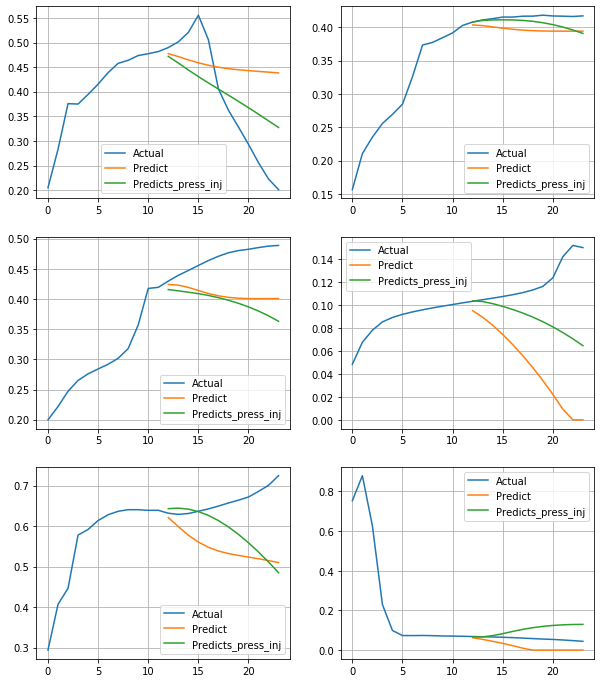

In [12]:
x_tst = data_tst[:, :n_months]
predicts_press_inj = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))

for i in range(n_months):
    x = np.concatenate((x_tst[:, i:], predicts_press_inj), axis=1)
    pred = model_press_inj.predict(x)
    last_pred = pred[:, -1:]
    predicts_press_inj = np.concatenate((predicts_press_inj, last_pred), axis=1)

data_tst = data_tst[:, :, :1]
x_tst = x_tst[:, :, :1]
predicts_press_inj = predicts_press_inj[:, :, :1]

plt.figure(figsize=(10, 2*n_graph))
for iapi in range(n_graph):
    plt.subplot(n_graph/2, 2, iapi+1)
    plt.plot(np.arange(data_tst.shape[1]), data_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts_prod.shape[1])+x_prod_tst.shape[1], predicts_prod[iapi, :, 0], label='Predict')
    plt.plot(np.arange(predicts_press_inj.shape[1])+x_tst.shape[1], predicts_press_inj[iapi, :, 0], label='Predicts_press_inj')
    plt.legend()
    plt.grid()
plt.show()

In [13]:
cum_second_year = data_tst[:, n_months:, :].sum(axis=1)*30
cum_model_prod = predicts_prod.sum(axis=1)*30
cum_model_press_inj = predicts_press_inj.sum(axis=1)*30

mae_model_prod = mean_absolute_error(cum_model_prod, cum_second_year)*max_prod
mae_model_press_inj = mean_absolute_error(cum_model_press_inj, cum_second_year)*max_prod

print("MAE for model_prod: ", mae_model_prod)
print("MAE for model_press_inj: ", mae_model_press_inj)

MAE for model_prod:  9458.662047750793
MAE for model_press_inj:  5858.494142701424


# Задача С: предсказание добычи за второй год по данным о добыче и мета-данным за первый

In [14]:
##############################################################################
## Model_meta_data are learned using "Production" and meta-data (24 months) ##
##############################################################################

parameters126months = pd.read_excel('parameters126months.xls')
numeric_features = ['pBub', 'initPres_pBub', 'temp_init', 'prBottomholePressure', 'well_dist']
x126months = parameters126months[numeric_features]
print("Parameters:")
display(x126months.head())
print("Parameters shape:", x126months.shape)

data_x126months = x126months.values
data_x126months_scal = data_x126months
for i in range(data_x126months_scal.shape[1]):
    data_x126months_scal[:, i] = data_x126months_scal[:, i] / data_x126months[:, i].max()

x126months_tr = data_x126months_scal[:int(x126months.shape[0]*0.75)]
x126months_tst = data_x126months_scal[int(x126months.shape[0]*0.75):]

# train
xmeta_tr = x126months_tr[:, np.newaxis, :]
xmeta_tr = np.repeat(xmeta_tr, x_data_prod.shape[1], axis=1)
xmeta_tr = np.repeat(xmeta_tr, 11, axis=0)
x_meta_data_tr = np.concatenate((xmeta_tr, x_data_prod), axis=-1)

# test
xmeta_tst = x126months_tst[:, np.newaxis, :]
xmeta_tst = np.repeat(xmeta_tst, x_data_prod.shape[1], axis=1)
x_meta_data_tst = np.concatenate((xmeta_tst, data_prod_tst[:, :n_months]), axis=-1)

print("x_meta_data train shape: ", x_meta_data_tr.shape)
print("x_meta_data test shape: ", x_meta_data_tst.shape)

Parameters:


,pBub,initPres_pBub,temp_init,prBottomholePressure,well_dist
0,101.661832,2.078974,61.712745,93.147141,624.679118
1,134.391772,1.645578,91.725640,46.097419,582.516094
2,121.390867,1.600563,76.245411,53.225667,542.177093
3,214.470349,1.540962,75.215659,255.768837,737.890236
4,154.389147,1.876674,87.009665,80.810029,338.498154


Parameters shape: (200, 5)
x_meta_data train shape:  (1650, 12, 6)
x_meta_data test shape:  (50, 12, 6)


In [15]:
inp = Input(shape=(n_months, 6))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(1, activation="relu")(lstm)

model_meta = Model(inp, out)
model_meta.summary()
model_meta.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12, 6)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 32)            4992      
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
dense_3 (Dense)              (None, 12, 1)             33        
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_meta.fit(x_meta_data_tr, y_data_prod, epochs=20)

Epoch 1/20
1650/1650 [==============================] - 1s 633us/step - loss: 0.0479 - mae: 0.1717
Epoch 2/20
1650/1650 [==============================] - 1s 352us/step - loss: 0.0235 - mae: 0.1151
Epoch 3/20
1650/1650 [==============================] - 1s 351us/step - loss: 0.0165 - mae: 0.0919
Epoch 4/20
1650/1650 [==============================] - 1s 352us/step - loss: 0.0116 - mae: 0.0739
Epoch 5/20
1650/1650 [==============================] - 1s 403us/step - loss: 0.0085 - mae: 0.0616
Epoch 6/20
1650/1650 [==============================] - 1s 350us/step - loss: 0.0066 - mae: 0.0528
Epoch 7/20
1650/1650 [==============================] - 1s 347us/step - loss: 0.0052 - mae: 0.0444
Epoch 8/20
1650/1650 [==============================] - 1s 352us/step - loss: 0.0043 - mae: 0.0406
Epoch 9/20
1650/1650 [==============================] - 1s 349us/step - loss: 0.0036 - mae: 0.0357
Epoch 10/20
1650/1650 [==============================] - 1s 347us/step - loss: 0.0031 - mae: 0.0322
Epoch 11/

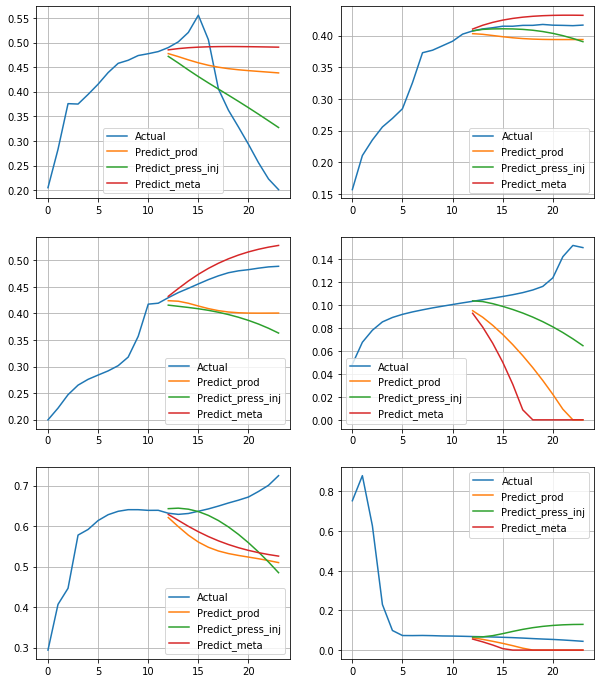

In [17]:
predicts_meta = np.zeros((x_meta_data_tst.shape[0], 0, 1))

for i in range(n_months):
    tmp = x_meta_data_tst[:, i:, 5].reshape(x_meta_data_tst.shape[0], n_months-i, 1)
    x = np.concatenate((tmp, predicts_meta), axis=1)
    x_pred = np.concatenate((x_meta_data_tst[:, :, :5], x), axis=2)
    pred = model_meta.predict(x_pred)
    last_pred = pred[:, -1:]
    predicts_meta = np.concatenate((predicts_meta, last_pred), axis=1)

plt.figure(figsize=(10, 2*n_graph))
for iapi in range(n_graph):
    plt.subplot(n_graph/2, 2, iapi+1)
    plt.plot(np.arange(data_tst.shape[1]), data_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts_prod.shape[1])+x_prod_tst.shape[1], predicts_prod[iapi, :, 0], label='Predict_prod')
    plt.plot(np.arange(predicts_press_inj.shape[1])+x_tst.shape[1], predicts_press_inj[iapi, :, 0], label='Predict_press_inj')
    plt.plot(np.arange(predicts_meta.shape[1])+x_prod_tst.shape[1], predicts_meta[iapi, :, 0], label='Predict_meta')
    plt.legend()
    plt.grid()
plt.show()

In [18]:
cum_model_meta = predicts_meta.sum(axis=1)*30
mae_model_meta = mean_absolute_error(cum_model_meta, cum_second_year)*max_prod

print("MAE for model_prod: ", mae_model_prod)
print("MAE for model_press_inj: ", mae_model_press_inj)
print("MAE for model_meta: ", mae_model_meta)

MAE for model_prod:  9458.662047750793
MAE for model_press_inj:  5858.494142701424
MAE for model_meta:  8084.798199828886


# Задача D: предсказание накопленной добычи за второй год с помощью XGBoost

In [20]:
###########################################################################
## XGBRegressor are learned using "Production" and meta-data (12 months) ##
###########################################################################

data_x_xgboost = np.zeros((data_x126months_scal.shape[0], data_x126months_scal.shape[1] + n_months))
data_y_xgboost = np.zeros((data_x126months_scal.shape[0], 1))

for i in range(data_x_xgboost.shape[0]):
    data_x_xgboost[i] = np.hstack((data_x126months_scal[i], data_prod[i][:n_months]))  
    
data_y_xgboost = data_prod[:, n_months:n_months_predict].sum(axis=1)*30
data_y_xgboost_scal = data_y_xgboost / data_y_xgboost.max()

print(data_y_xgboost_scal[0])

data_x_xgboost_tr = data_x_xgboost[:int(data_x_xgboost.shape[0]*0.75)]
data_x_xgboost_tst = data_x_xgboost[int(data_x_xgboost.shape[0]*0.75):]

data_y_xgboost_tr = data_y_xgboost_scal[:int(data_y_xgboost_scal.shape[0]*0.75)]
data_y_xgboost_tst = data_y_xgboost_scal[int(data_y_xgboost_scal.shape[0]*0.75):]

model_xgboost = XGBRegressor(objective = 'reg:squarederror')
model_xgboost.fit(data_x_xgboost_tr, data_y_xgboost_tr)
predict_xgboost = model_xgboost.predict(data_x_xgboost_tst)*data_y_xgboost.max()
mae_xgboost = mean_absolute_error(predict_xgboost, cum_second_year)*max_prod

print(data_y_xgboost_tr.shape)

0.6290814482620672
(150,)


In [21]:
print("MAE for model_prod: ", mae_model_prod)
print("MAE for model_press_inj: ", mae_model_press_inj)
print("MAE for model_meta: ", mae_model_meta)
print('MAE for XGBRegressor:', mae_xgboost) 

MAE for model_prod:  9458.662047750793
MAE for model_press_inj:  5858.494142701424
MAE for model_meta:  8084.798199828886
MAE for XGBRegressor: 6275.376542113343


# Задача E: восстановление истории разработки по данным о дебите в прошлом месяце и мета-данным

In [22]:
##############################################################################
## Model126months are learned using "Production" and meta-data (126 months) ##
##############################################################################

production126months = pd.read_excel('production126months.xlsx')
print("Production 1-126 months:")
display(production126months.head())

data_production126months = production126months.values
data_production126months_scal = data_production126months / data_production126months.max()

data_x = np.zeros((data_x126months_scal.shape[0], history_len-1, data_x126months_scal.shape[1]+1))
data_y = np.zeros((data_x126months_scal.shape[0], history_len-1, 1))

for i in range(data_x126months_scal.shape[0]):
    for j in range(history_len-1):
        data_x[i][j] = np.hstack((data_x126months_scal[i], data_production126months_scal[i][j]))
        data_y[i][j] = data_production126months_scal[i][j+1]

data_x_tr = data_x[:int(data_x.shape[0]*0.75)]
data_x_tst = data_x[int(data_x.shape[0]*0.75):]

data_y_tr = data_y[:int(data_y.shape[0]*0.75)]
data_y_tst = data_y[int(data_y.shape[0]*0.75):]

print("data_x_train shape:", data_x_tr.shape)
print("data_x_test shape:", data_x_tst.shape)
print("data_y_train shape:", data_y_tr.shape)
print("data_y_test shape:", data_y_tst.shape)

Production 1-126 months:


,30,60,90,120,150,180,210,240,270,300,...,3510,3540,3570,3600,3630,3660,3690,3720,3750,3780
0,67.4941,89.1393,103.3100,113.689,120.6310,157.0800,153.7660,158.0670,163.423,167.826,...,17.4092,17.3782,17.3473,17.3291,17.3088,17.2827,17.2624,17.2147,17.1407,17.0807
1,119.0390,158.2370,174.1520,196.079,236.6280,241.6010,250.8850,256.4400,259.848,260.841,...,21.4554,21.4002,21.3548,21.3101,21.2592,21.2001,21.1403,21.0720,21.0085,20.9533
2,105.2020,147.0960,160.8720,208.552,223.8190,232.8640,240.8040,247.8540,253.325,255.225,...,21.5236,21.4735,21.4325,21.3831,21.3283,21.2548,21.1756,21.0995,21.0292,20.9532
3,33.8452,37.0500,40.3715,42.894,44.6663,46.0704,47.2206,48.2475,49.097,49.875,...,91.0711,91.4513,91.7620,92.1242,92.5644,93.0378,93.3615,93.9216,94.7317,95.5013
4,163.6050,244.1620,264.1410,286.023,296.6880,300.8600,303.6640,320.9160,278.395,174.037,...,4.0167,4.0167,4.0167,4.0167,4.0167,4.0167,4.0167,4.0167,3.1579,3.1201


data_x_train shape: (150, 125, 6)
data_x_test shape: (50, 125, 6)
data_y_train shape: (150, 125, 1)
data_y_test shape: (50, 125, 1)


In [23]:
inp = Input(shape=(history_len-1, 6))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(1, activation="relu")(lstm)

model126months = Model(inp, out)
model126months.summary()
model126months.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 125, 6)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 125, 32)           4992      
_________________________________________________________________
lstm_8 (LSTM)                (None, 125, 32)           8320      
_________________________________________________________________
dense_4 (Dense)              (None, 125, 1)            33        
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________


In [24]:
model126months.fit(data_x_tr, data_y_tr, epochs=20)

Epoch 1/20
150/150 [==============================] - 1s 7ms/step - loss: 0.0318 - mae: 0.1413
Epoch 2/20
150/150 [==============================] - 1s 4ms/step - loss: 0.0237 - mae: 0.1156
Epoch 3/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0170 - mae: 0.0909
Epoch 4/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0114 - mae: 0.0775
Epoch 5/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0088 - mae: 0.0627
Epoch 6/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0079 - mae: 0.0589
Epoch 7/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0073 - mae: 0.0537
Epoch 8/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0070 - mae: 0.0529
Epoch 9/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0065 - mae: 0.0508
Epoch 10/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0061 - mae: 0.0479
Epoch 11/20
150/150 [============================

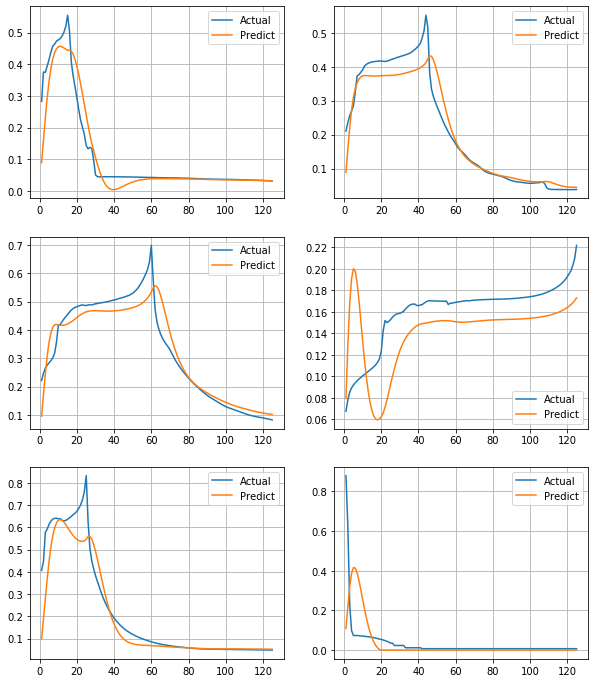

In [25]:
predicts_126months = np.zeros((data_y_tst.shape[0], data_y_tst.shape[1], data_y_tst.shape[2]))

for i in range(data_y_tst.shape[0]):
    cur_x = data_x_tst[i].reshape(1, data_x_tst[i].shape[0], data_x_tst[i].shape[1])
    predicts_126months[i] = model126months.predict(cur_x)

plt.figure(figsize=(10, 2*n_graph))
for i in range(n_graph):
    plt.subplot(n_graph/2, 2, i+1)
    month = np.arange(data_y_tst.shape[1]) + 1
    plt.plot(month, data_y_tst[i], label='Actual')
    plt.plot(month, predicts_126months[i], label='Predict')
    plt.legend()
    plt.grid()
plt.show()

In [26]:
cum_predicts_126months = predicts_126months.sum(axis=1)*30

print(predicts_126months.shape)
print(data_y_tst.shape)

cum_real_126months = data_y_tst.sum(axis=1)*30

mae_126months = mean_absolute_error(cum_predicts_126months, cum_real_126months)*data_production126months.max()
print(mae_126months)

(50, 125, 1)
(50, 125, 1)
15686.125983348456
